<a href="https://colab.research.google.com/github/YifanSong348/STATS303/blob/main/HW/STATS303_Week_3_Spectral_clustering_vs_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 3 - Homework - Yifan Song (ys251)
###Problem 3. Programming: Spectral clustering vs K-means

In [ ]:
import numpy as np
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


##In $R^2$, for each of the three concentric clusters with radius `1, 2.8` and `5`, generate `150` points. Add a noise $∼ N (0, 0.25^2)$ to each of the `450` points to form your dataset.

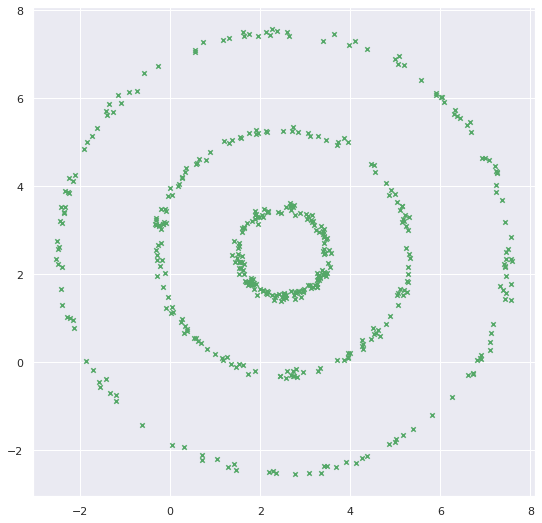

In [ ]:
# KMeans
# # Class=3
# Center(2.5,2.5), r1 = 1, r2 = 2.8, r3 = 5
X1 = np.zeros(450)
X2 = np.zeros(450)

r1 = 1; r2 = 2.8; r3 = 5; a = 2.5; b = 2.5; c = 2.5 # generate circle

h = np.random.uniform(0, 2*np.pi, 150)
noise = np.random.normal(0, 0.25**2, 150)
X1[:150] = np.cos(h) * r1 + a + noise
noise = np.random.normal(0, 0.25**2, 150)
X2[:150] = np.sin(h) * r1 + a + noise

h = np.random.uniform(0, 2*np.pi, 150)
# noise = np.random.normal(0, 0.25**2, 150)
X1[150:300] = np.cos(h) * r2 + b + noise
noise = np.random.normal(0, 0.25**2, 150)
X2[150:300] = np.sin(h) * r2 + b + noise

h = np.random.uniform(0, 2*np.pi, 150)
# noise = np.random.normal(0, 0.25**2, 150)
X1[300:] = np.cos(h) * r3 + c + noise
noise = np.random.normal(0, 0.25**2, 150)
X2[300:] = np.sin(h) * r3 + c + noise


X = np.array([X1,X2]).T

plt.figure(figsize=(9,9))
plt.scatter(X[:,0],X[:,1],marker="x",color='g',s=20)

##**1.** Using K-means with *K* = 3, cluster the data points. Show your results in 2D and in three colors.

In [ ]:
class K_Means:
    def __init__(self, k=3, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

19.60263515473678
59.51577178392557


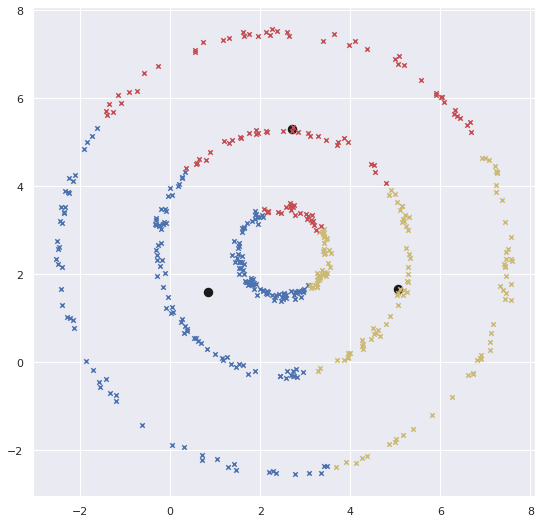

In [ ]:
model = K_Means()
model.fit(X)

for centroid in model.centroids:
    plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="o", color="k", s=20, linewidths=5)

for classification in model.classifications:
    colors = ['b', 'y', 'r']
    color = colors[classification]
    for featureset in model.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=20, linewidths=5)
# plt.axis([-10, 10, -5, 15])  
fig = plt.gcf()
fig.set_size_inches(9, 9)      
plt.show()

##**2.** Construct a similarity graph with k-NN where k = 10. Plot the graph Laplacian *L* (“plt.imshow” your matrix).

In [ ]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

In [ ]:
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

In [ ]:
# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

##**3.** Construct the feature matrix *Z* (which is 450 × 2 using the two eigenvectors of *L* corresponding to the second and the third smallest eigenvalues. Then, using K-means with *K* = 3, cluster the features. Show your results in 2D for the original data points.